# Lewinson Chapter 2 - Technical Analysis in Python

## Introduction

Chapter 2 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) discusses a handful of trading strategies based on technical analysis.

We will focus on implementing and evaluating a trading strategy based on past prices and returns.

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')
import yfinance as yf
import pandas_datareader as pdr

## Backtesting a Strategy Based on Simple Moving Average

Lewinson uses the backtrader package to implement his technical trading strategies.
However, there are no recent code commits to [backtrader's GitHub repository](https://github.com/mementum/backtrader), so it may be abandoned.
So we manually implement these stategies and learn a lot in the process!

The first strategy is a simple moving average (SMA) stategy that:

> For this recipe, we consider a basic strategy based on the SMA. The key points of the strategy are as follows:
>
>   - When the close price becomes higher than the 20-day SMA, buy one share.
>   - When the close price becomes lower than the 20-day SMA and we have a share, sell it.
>   - We can only have a maximum of one share at any given time.
>   - No short selling is allowed.

We do these calculations in *dollar* terms instead of *share* terms.

In [4]:
aapl = yf.download('AAPL', session=session)
aapl.index = aapl.index.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


Second, we calculate daily returns and add SMA(20) for the adjusted close.
We use the adjust close because we do not want to misinterpret splits and dividends as price changes.

In [5]:
aapl['AAPL'] = aapl['Adj Close'].pct_change()
aapl['SMA20'] = aapl['Adj Close'].rolling(20).mean()

Third, we add a `Position` column based on AAPL's adjusted close and SMA(20) columns.
`Position` takes one of two values: `1` if we are long AAPL and `0` if we are neutral AAPL.
`np.select()` avoids nested `np.where()` and accepts a default.
We `.shift()` inputs one day because we do not know closing prices and SMA(20) until the end of the day.
Therefore, we cannot update `Position` until the next trading day.

In [6]:
aapl['Position'] = np.select(
    condlist=[
        aapl['Adj Close'].shift() > aapl['SMA20'].shift(), # .shift() to use lagged values to prevent look-ahead bias
        aapl['Adj Close'].shift() <= aapl['SMA20'].shift() # .shift() has a default of looking up one row
    ], 
    choicelist=[
        1, 
        0
    ],
    default=np.nan
)

I find the following two steps helpful.
First, plot the adjusted close, SMA(20), and position for a short window.

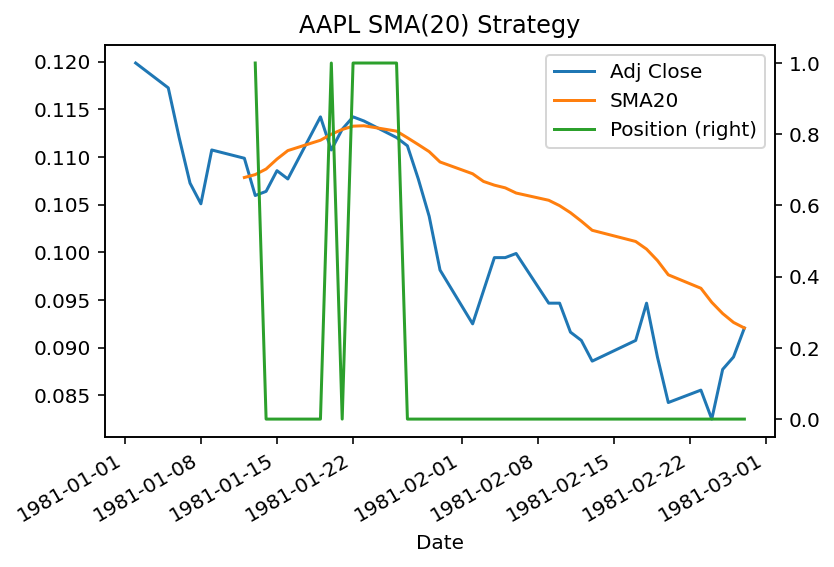

In [7]:
aapl.loc['1981-01':'1981-02', ['Adj Close', 'SMA20', 'Position']].plot(secondary_y='Position')
plt.title('AAPL SMA(20) Strategy')
plt.show()

Second, copy-and-paste these data to Excel!
Excel is an excellent place to check your work!

In [8]:
# aapl.loc[:'1981-02'].to_clipboard()

Finally, we create a `Strategy` column that provides the return on the strategy.
We will assume that we earn a cash return of 0% when we are neutral AAPL.

In [9]:
aapl['Strategy'] = aapl['Position'] * aapl['AAPL']

In [10]:
aapl[['Adj Close', 'SMA20', 'Position', 'AAPL', 'Strategy']].dropna().head()

,Adj Close,SMA20,Position,AAPL,Strategy
Date,,,,,
1981-01-13,0.1060,0.1081,1.0000,-0.0356,-0.0356
1981-01-14,0.1064,0.1087,0.0000,0.0041,0.0000
1981-01-15,0.1086,0.1098,0.0000,0.0204,0.0000
1981-01-16,0.1077,0.1107,0.0000,-0.0080,-0.0000
1981-01-19,0.1142,0.1118,0.0000,0.0605,0.0000


We can plot the cumulative return on 1 dollar invested in this SMA(20) strategy.
We drop missing values to make an apples-to-apples comparison between the buy-and-hold and SMA(20) strategies.
There may be missing values for both strategies because:

1. We need 2 days to calculate 1 daily return 
1. We need 20 days to calculate the first SMA(20)

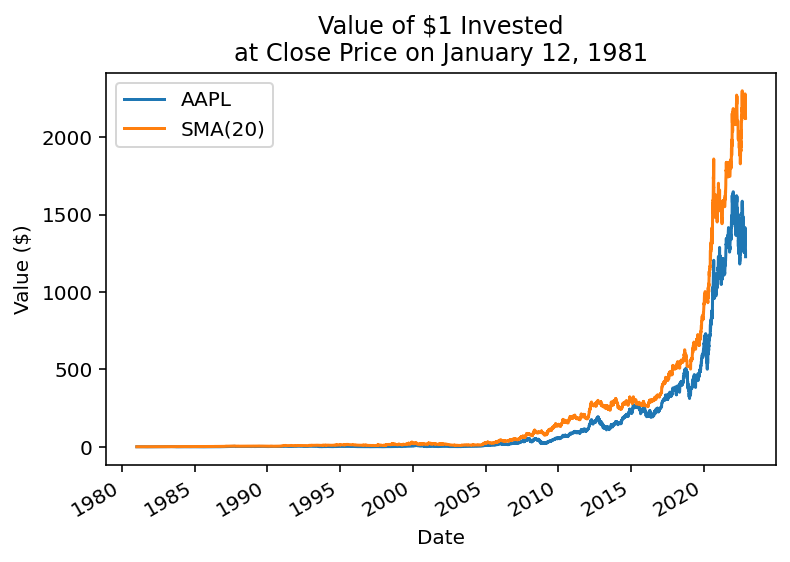

In [11]:
(
    aapl
    [['AAPL', 'Strategy']]
    .dropna()
    .add(1)
    .cumprod()
    .rename(columns={'Strategy': 'SMA(20)'})
    .plot()
)
buy_date = (
    aapl
    [['AAPL', 'Strategy']]
    .dropna()
    .index[0] - 
    pd.offsets.BDay(1)
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested\nat Close Price on {buy_date:%B %d, %Y}')
plt.show()

## Calculating Bollinger Bands and testing a buy/sell strategy

John Bollinger developed Bollinger Bands in the early 1980s.
He describes Bollinger Bands as follows:

> So what are Bollinger Bands? They are curves drawn in and around the price structure usually consisting of a moving average (the middle band), an upper band, and a lower band that answer the question as to whether prices are high or low on a relative basis. Bollinger Bands work best when the middle band is chosen to reflect the intermediate-term trend, so that trend information is combined with relative price level data.

More [here](https://www.bollingerbands.com/bollinger-bands).
John Bollinger provides a list of rules [here](https://www.bollingerbands.com/bollinger-band-rules).
In short, Bollinger Bands are bands around a trend (typically $\mu_{price} \pm 2\sigma_{price}$ using 20 trading days).
Technical analysts use these bands to signal high and low prices.

Lewinson builds Bollinger Bands with the backtrader package, but we will build Bollinger Bands with pandas.
Lewinson desribes Bollinger Bands as follows:

> Bollinger Bands are a statistical method, used for deriving information about the prices and volatility of a certain asset over time. To obtain the Bollinger Bands, we need to calculate the moving average and standard deviation of the time series (prices), using a specified window (typically, 20 days). Then, we set the upper/lower bands at K times (typically, 2) the moving standard deviation above/below the moving average.
>
> The interpretation of the bands is quite sample: the bands widen with an increase in volatility and contract with a decrease in volatility.
> 
> In this recipe, we build a simple trading strategy, with the following rules:
>
>    - Buy when the price crosses the lower Bollinger Band upwards.
>    - Sell (only if stocks are in possession) when the price crosses the upper Bollinger Band downward.
>    - All-in strategy—when creating a buy order, buy as many shares as possible.
>    - Short selling is not allowed.

We will implement Lewinson's strategy with Tesla.
First, we will plot the 20-day rolling means and plus/minus 2 standard deviations.

In [12]:
tsla = yf.download('TSLA', session=session)
tsla.index = tsla.index.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


In [13]:
tsla['TSLA'] = tsla['Adj Close'].pct_change()

In [14]:
win = 20
K = 2
tsla[['SMA20', 'SMV20']] = tsla['Adj Close'].rolling(win).agg(['mean', 'std'])
tsla['LB20'] = tsla['SMA20'] - K*tsla['SMV20']
tsla['UB20'] = tsla['SMA20'] + K*tsla['SMV20']

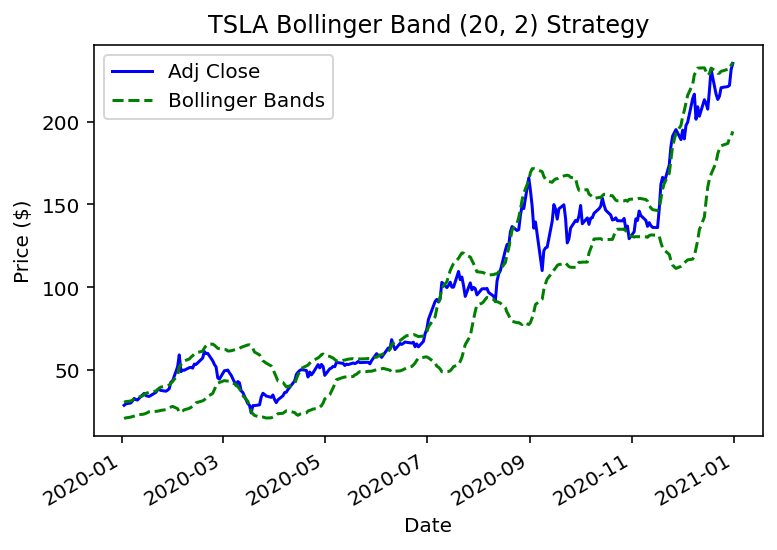

In [15]:
tsla.loc['2020', ['Adj Close', 'LB20', 'UB20']].plot(style=['b-', 'g--', 'g--'])
plt.legend(['Adj Close', 'Bollinger Bands'])
plt.ylabel('Price ($)')
plt.title(f'TSLA Bollinger Band ({win}, {K}) Strategy')
plt.show()

We will implement the TSLA Bollinger Band (20, 2) strategy in class.

The following code highlights ***possible changes*** in position.

In [16]:
tsla['Position'] = np.select(
    condlist=[
        (tsla['Adj Close'] > tsla['LB20']).shift(1) & 
            (tsla['Adj Close'] <= tsla['LB20']).shift(2),
        (tsla['Adj Close'] < tsla['UB20']).shift(1) & 
            (tsla['Adj Close'] >= tsla['UB20']).shift(2)
    ], 
    choicelist=[
        1,
        0
    ],
    default=np.nan
)

The following code carries forward our last change in position.

In [17]:
tsla['Position'] = tsla['Position'].fillna(method='ffill')

The following code puts together the return on the BB(20, 2) strategy.

In [18]:
tsla['Strategy'] = tsla['Position'] * tsla['TSLA']

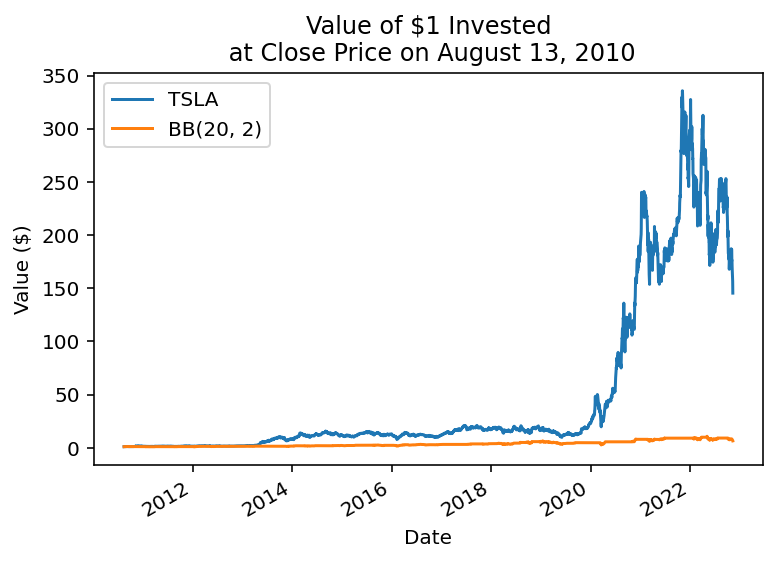

In [19]:
(
    tsla
    [['TSLA', 'Strategy']]
    .dropna()
    .add(1)
    .cumprod()
    .rename(columns={'Strategy': 'BB(20, 2)'})
    .plot()
)
buy_date = (
    tsla
    [['TSLA', 'Strategy']]
    .dropna()
    .index[0] - 
    pd.offsets.BDay(1)
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested\n at Close Price on {buy_date:%B %d, %Y}')
plt.show()

## Calculating the relative strength index and testing a long/short strategy

Lewinson describes the relative strength index (RSI) as follows:

> The RSI is an indicator that uses the closing prices of an asset to identify oversold/overbought conditions. Most commonly, the RSI is calculated using a 14-day period, and it is measured on a scale from 0 to 100 (it is an oscillator). Traders usually buy an asset when it is oversold (if the RSI is below 30), and sell when it is overbought (if the RSI is above 70). More extreme high/low levels, such as 80-20, are used less frequently and, at the same time, imply stronger momentum.
> 
> In this recipe, we build a trading strategy with the following rules:
>
>    - We can go long and short.
>    - For calculating the RSI, we use 14 periods (trading days).
>    - Enter a long position if the RSI crosses the lower threshold (standard value of 30) upwards; exit the position when the RSI becomes larger than the middle level (value of 50).
>    - Enter a short position if the RSI crosses the upper threshold (standard value of 70) downwards; exit the position when the RSI becomes smaller than 50.
>    - Only one position can be open at a time.

Lewinson uses a package to calculate the RSI and implement his strategy above.
We do not need a package!
Here is RSI's formula: $$RSI = 100 - \frac{100}{1 + RS},$$ where $$RS = \frac{SMA(U, n)}{SMA(D, n)}.$$
For "up days", $U = \Delta Adj\ Close$ and $D = 0$.
For "down days", $U = 0$ and $D = - \Delta Adj\ Close$, so that $U$ and $D$ are always non-negative.
We can learn more about RSI [here](https://en.wikipedia.org/wiki/Relative_strength_index).

We will use Tesla data, again, for this section, but in a new data frame `tsla2`.

In [20]:
tsla2 = yf.download('TSLA', session=session)

[*********************100%***********************]  1 of 1 completed


In [21]:
tsla2['TSLA'] = tsla2['Adj Close'].pct_change()

First, we will write a function `rsi()` that calculates $RSI$ for a return series.
Here are some details:

1. We will make `rsi()`'s accept a series `x`, which can be either a series of dollar changes or a series of simple returns
1. We will make `rsi()`'s default window `n=14`

Second, we will use `rsi()` to implement the RSI(14) strategy for TSLA.

In [22]:
win2 = 14
lb2 = 30
mb2 = 50
ub2 = 70

In [23]:
def rsi(x, n=14):
    _U = np.maximum(x, 0)
    _D = -1 * np.minimum(x, 0)
    _RS = _U.rolling(n).mean() / _D.rolling(n).mean()
    return 100 - 100 / (1 + _RS)

In [24]:
tsla2['RSI'] = rsi(x=tsla2['TSLA'], n=win2)

In [25]:
tsla2['Position'] = np.select(
    condlist=[
        (tsla2['RSI'].shift(1) > lb2) & (tsla2['RSI'].shift(2) <= lb2),
        (tsla2['RSI'].shift(1) > mb2) & (tsla2['RSI'].shift(2) <= mb2),
        (tsla2['RSI'].shift(1) < ub2) & (tsla2['RSI'].shift(2) >= ub2),
        (tsla2['RSI'].shift(1) < mb2) & (tsla2['RSI'].shift(2) >= mb2),
    ], 
    choicelist=[1, 0, -1, 0],
    default=np.nan
)
tsla2['Position'].fillna(method='ffill', inplace=True)

In [26]:
tsla2['Strategy'] = tsla2['Position'] * tsla2['TSLA']

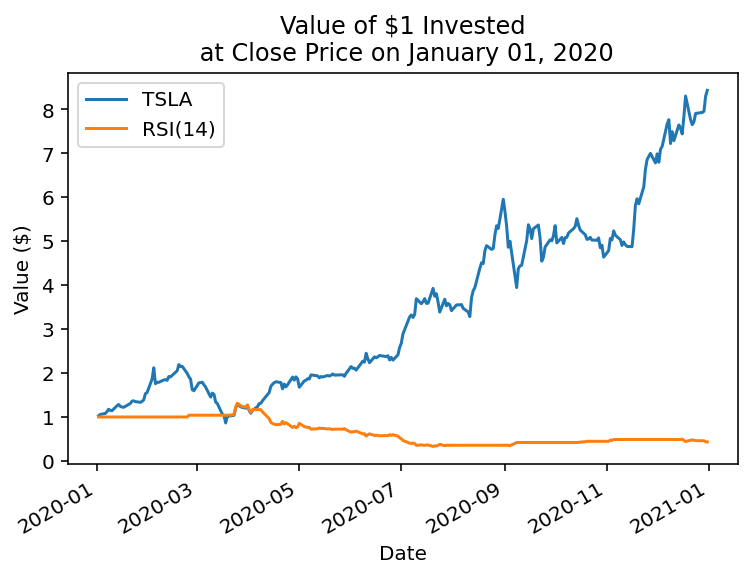

In [27]:
(
    tsla2
    .loc['2020', ['TSLA', 'Strategy']]
    .dropna()
    .add(1)
    .cumprod()
    .rename(columns={'Strategy': 'RSI(14)'})
    .plot()
)
buy_date = (
    tsla2
    .loc['2020', ['TSLA', 'Strategy']]
    .dropna()
    .index[0] - 
    pd.offsets.BDay(1)
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested\n at Close Price on {buy_date:%B %d, %Y}')
plt.show()

## Practice

***Practice:***
Implement the SMA(20) strategy above with AAPL with one chained calculation.
Save assign this new data frame to `aapl2`.

In [28]:
def sma(df, window=20):
    return df.assign(
        RET = lambda x: x['Adj Close'].pct_change(),
        SMA20 = lambda x: x['Adj Close'].rolling(window).mean(),
        Position = lambda x: np.select(
            condlist=[
                x['Adj Close'].shift() > x['SMA20'].shift(),
                x['Adj Close'].shift() <= x['SMA20'].shift()
            ], 
            choicelist=[
                1, 
                0
            ],
            default=np.nan
        ),
        Strategy = lambda x: x['Position'] * x['RET']
    )

In [29]:
aapl2 = sma(aapl.iloc[:, :6])

***Practice:***
Use `np.allclose()` to compare `aapl` and `aapl2`.

In [30]:
np.allclose(aapl, aapl, equal_nan=True)

True

In [31]:
np.allclose(aapl, aapl2, equal_nan=True)

True

***Practice:***
What is the full-sample Sharpe Ratio for the SMA(20) strategy with AAPL?
Use the risk-free rate `RF` from Ken French's daily factors.

In [32]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900')[0].div(100)

In [33]:
def sharpe_ratio(r, bm, ann_fac=np.sqrt(252)):
    er = r.sub(bm, axis=0)
    return ann_fac * er.mean() / er.std()

In [34]:
sharpe_ratio(r=aapl[['AAPL', 'Strategy']].dropna(), bm=ff['RF'])

AAPL       0.5263
Strategy   0.6384
dtype: float64

We can also `.pipe()` to the `sharpe_ratio()` function to keep a left-to-right sentence structure.

In [35]:
aapl[['AAPL', 'Strategy']].dropna().pipe(sharpe_ratio, bm=ff['RF'])

AAPL       0.5263
Strategy   0.6384
dtype: float64

***Practice:***
The AAPL SMA(20) strategy outperformed buy-and-hold for the full sample.
How do SMA(20) and buy-and-hold perform over rolling 6-month windows?
Plot the values of $1 invested in each for all possible 126-trading day windows.

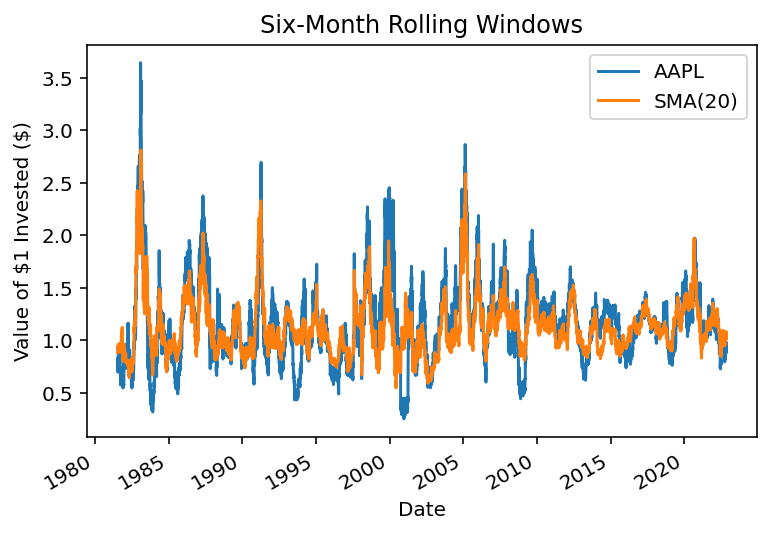

In [36]:
(
    aapl[['AAPL', 'Strategy']]
    .dropna()
    .rolling(126)
    .apply(lambda x: (1 + x).prod())
    .rename(columns={'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value of \$1 Invested ($)')
plt.title('Six-Month Rolling Windows')
plt.show()

We can take the ratio of SMA(20) to AAPL as a measure of outperformance.
In some cases SMA(20) outperformance by 2x or more, but otherwise SMA(20) has no clear advantage over buy-and-hold.

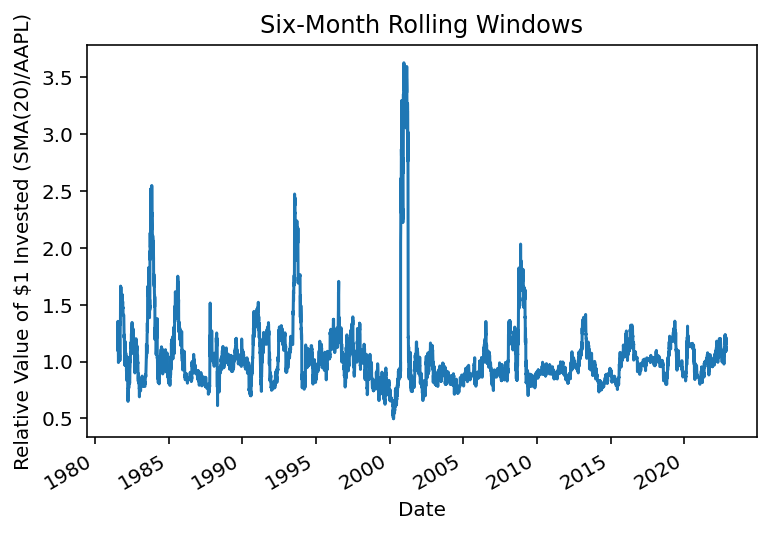

In [37]:
(
    aapl[['AAPL', 'Strategy']]
    .dropna()
    .rolling(126)
    .apply(lambda x: (1 + x).prod())
    .assign(strat_appl = lambda x: x['Strategy'] / x['AAPL'])
    ['strat_appl']
    .plot()
)
plt.ylabel('Relative Value of \$1 Invested (SMA(20)/AAPL)')
plt.title('Six-Month Rolling Windows')
plt.show()

Can we speed up this code?!

In [38]:
%%timeit
(
    aapl[['AAPL', 'Strategy']]
    .dropna()
    .rolling(126)
    .apply(lambda x: (1 + x).prod())
)

1.8 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Yes!
We can pick the low-hanging fruit with `apply()`'s `raw=True` argument, which removes the cruft and structure of pandas and passes the NumPy array directly to `np.prod()`.

In [39]:
%%timeit
(
    aapl[['AAPL', 'Strategy']]
    .dropna()
    .rolling(126)
    .apply(lambda x: (1 + x).prod(), raw=True)
)

46.9 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


But we should switch to summing log returns if we need large speed gains.
The following code is faster than the two options above because the `.sum()` method is optimized.
We can sum log returns (then exponentiate) because the log of products is the sum of logs.
For example,
$$1+R_{Total} = (1+R_1)(1+R2)\cdots(1+R_T),$$
and then we exponentiate then log both sides
$$\exp(\log(1+R_{Total})) = \exp(\log((1+R_1)(1+R2)\cdots(1+R_T))),$$
and then the log of products is sum of logs
$$\exp(\log(1+R_{Total})) = \exp(\log(1+R_1) + \log(1+R_2) + \cdots + \log(1+R_T))) = \exp\left(\sum_{t=1}^{T} \log(1+R_t)\right),$$
so
$$R_{Total} = \exp\left(\sum_{t=1}^{T} \log(1+R_t)\right) - 1$$

In [40]:
%%timeit
(
    aapl[['AAPL', 'Strategy']]
    .dropna()
    .pipe(np.log1p)
    .rolling(126)
    .sum()
    .pipe(np.exp)
    .sub(1)
)

1.28 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


***Practice:***
Implement the BB(20, 2) strategy above with TSLA with one chained calculation.
Save assign this new data frame to `tsla3`.

In [41]:
def bb(df, win=20, K=2):
    return (
        df
        .assign(
            RET=lambda x: x['Adj Close'].pct_change(),
            SMA=lambda x: x['Adj Close'].rolling(win).mean(),
            SMV=lambda x: x['Adj Close'].rolling(win).std(),
            LB=lambda x: x['SMA'] - K*x['SMV'],
            UB=lambda x: x['SMA'] + K*x['SMV'],
            _Position=lambda x: np.select( # cannot modify a column twice, so we make a temporary column that we later drop
                condlist=[
                    (x['Adj Close'] > x['LB']).shift(1) & (x['Adj Close'] <= x['LB']).shift(2),
                    (x['Adj Close'] < x['UB']).shift(1) & (x['Adj Close'] >= x['UB']).shift(2)
                ], 
                choicelist=[
                    1,
                    0
                ],
                default=np.nan
            ),
            Position=lambda x: x['_Position'].fillna(method='ffill'),
            Strategy=lambda x: x['Position'] * x['RET']
        )
        .drop(columns='_Position')
    )


In [42]:
tsla3 = bb(tsla.iloc[:, :6])

In [43]:
np.allclose(tsla, tsla3, equal_nan=True)

True

***Practice:***
What is the full-sample Sharpe Ratio for the BB(20, 2) strategy with TSLA?
Use the risk-free rate `RF` from Ken French's daily factors.

In [44]:
tsla[['TSLA', 'Strategy']].dropna().pipe(sharpe_ratio, bm=ff['RF'])

TSLA       1.0594
Strategy   0.6685
dtype: float64

***Practice:***
Implement the RSI(14) strategy above with TSLA with one chained calculation.
Save assign this new data frame to `tsla4`.

In [45]:
def rsi(df, win=14, lb=30, mb=50, ub=70):

    # we can define an _rsi() function for use inside the outer rsi() function
    def _rsi(x, n):
        _U = np.maximum(x, 0)
        _D = -1 * np.minimum(x, 0)
        _RS = _U.rolling(n).mean() / _D.rolling(n).mean()
        return 100 - 100 / (1 + _RS)

    return (
        df.assign(
            RET = lambda x: x['Adj Close'].pct_change(),
            RSI = lambda x: _rsi(x=x['RET'], n=win),
            Position_ = lambda x: np.select(
                condlist=[
                    (x['RSI'].shift(1) > lb) & (x['RSI'].shift(2) <= lb),
                    (x['RSI'].shift(1) > mb) & (x['RSI'].shift(2) <= mb),
                    (x['RSI'].shift(1) < ub) & (x['RSI'].shift(2) >= ub),
                    (x['RSI'].shift(1) < mb) & (x['RSI'].shift(2) >= mb),
                ], 
                choicelist=[1, 0, -1, 0],
                default=np.nan
            ),
            Position = lambda x: x['Position_'].fillna(method='ffill'),
            Strategy = lambda x: x['Position'] * x['RET'],
        )
        .drop(columns='Position_')
    )

In [46]:
tsla2.iloc[:, :6]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.2667,1.6667,1.1693,1.5927,1.5927,281494500
2010-06-30,1.7193,2.0280,1.5533,1.5887,1.5887,257806500
2010-07-01,1.6667,1.7280,1.3513,1.4640,1.4640,123282000
2010-07-02,1.5333,1.5400,1.2473,1.2800,1.2800,77097000
2010-07-06,1.3333,1.3333,1.0553,1.0740,1.0740,103003500
...,...,...,...,...,...,...
2022-11-03,211.3600,221.2000,210.1400,215.3100,215.3100,56538800
2022-11-04,222.6000,223.8000,203.0800,207.4700,207.4700,98453100
2022-11-07,208.6500,208.9000,196.6600,197.0800,197.0800,93916500


In [47]:
tsla4 = rsi(df=tsla2.iloc[:, :6])

In [48]:
np.allclose(tsla2, tsla4, equal_nan=True)

True

***Practice:***
What is the full-sample Sharpe Ratio for the RSI(14) strategy with TSLA?
Use the risk-free rate `RF` from Ken French's daily factors.

In [49]:
tsla2[['TSLA', 'Strategy']].dropna().pipe(sharpe_ratio, bm=ff['RF'])

TSLA        1.0337
Strategy   -0.5442
dtype: float64